In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
import itk
from matplotlib import pyplot as plt
import numpy as np
import pydicom
import sys

In [2]:
def crop_slice(img, centerx, centery, xd, yd):
    y,x = img.shape
    startx = centerx-(xd//2)
    starty = centery-(yd//2)
    return img[starty:starty+yd, startx:startx+xd]


In [10]:
fixed_image_filename =  '/mnt/storage/ITK/WatchRegistration/build/sample1.jpg'
moving_image_filename = '/mnt/storage/ITK/WatchRegistration/build/sample2.jpg'

Dimension = 2
FloatPixelType = itk.ctype('float')
FloatImageType = itk.Image[FloatPixelType, Dimension]

fixed_reader = itk.ImageFileReader[FloatImageType].New()
fixed_reader.SetFileName(fixed_image_filename)

moving_reader = itk.ImageFileReader[FloatImageType].New()
moving_reader.SetFileName(moving_image_filename)

fixed_reader.Update()
moving_reader.Update()

In [11]:
fixed_normalizer = itk.NormalizeImageFilter.New(Input = fixed_reader.GetOutput())
moving_normalizer = itk.NormalizeImageFilter.New(Input = moving_reader.GetOutput())

In [12]:
fixed_smoother = itk.DiscreteGaussianImageFilter.New(Input=fixed_normalizer.GetOutput(), Variance=2.0)
moving_smoother= itk.DiscreteGaussianImageFilter.New(Input=moving_normalizer.GetOutput(), Variance=2.0)

In [13]:
fixed_smoother.Update()
moving_smoother.Update()

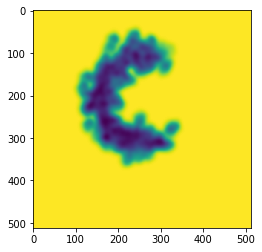

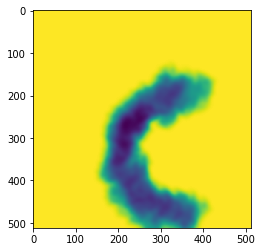

In [14]:
plt.imshow(itk.GetArrayFromImage(fixed_smoother.GetOutput()))
plt.show()
plt.imshow(itk.GetArrayFromImage(moving_smoother.GetOutput()))
plt.show()

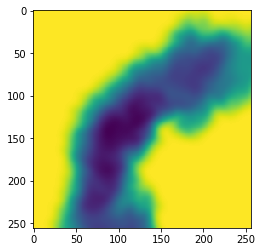

In [15]:
moving_slice = crop_slice(itk.GetArrayFromImage(moving_smoother.GetOutput()),256,256,256,256)
plt.imshow(moving_slice)
plt.show()

In [16]:
transform = itk.AffineTransform.New()
optimizer = itk.GradientDescentOptimizer.New()
interpolator = itk.LinearInterpolateImageFunction.New()
metric = itk.MutualInformationImageToImageMetric.New()
registration = itk.ImageRegistrationMethod.New(Metric=metric, Optimizer=optimizer, Transform=transform,Interpolator=interpolator)

AttributeError: 'itkImageSS2' object has no attribute 'GetOutput'

In [17]:
metric.SetFixedImageStandardDeviation(0.4)
metric.SetMovingImageStandardDeviation(0.4)
registration.SetFixedImage(itk.CastImageFilter(Input=fixed_smoother.GetOutput()))
registration.SetMovingImage(itk.CastImageFilter(Input=itk.GetImageFromArray(moving_slice)))
#moving_smoother.GetOutput()))

fixed_normalizer.Update()
fixed_image_region = fixed_normalizer.GetOutput().GetBufferedRegion()

registration.SetFixedImageRegion(fixed_image_region)

initial_parameters = transform.GetParameters();
#rot mat
initial_parameters[0] =0.0
initial_parameters[1] =1.0
initial_parameters[2] =0.0
initial_parameters[3] =1.0
#translate
initial_parameters[4]=0
initial_parameters[5] =0

registration.SetInitialTransformParameters(initial_parameters)

In [18]:
number_of_pixels = fixed_image_region.GetNumberOfPixels()
number_of_samples = number_of_pixels /10


In [19]:
metric.SetNumberOfSpatialSamples(int(number_of_samples))
optimizer.SetLearningRate(5.0)
optimizer.SetNumberOfIterations(100)
optimizer.MaximizeOn()

In [ ]:
registration.Update()

In [64]:
final_parameters = registration.GetLastTransformParameters()

In [65]:
final_parameters[5]

0.0

In [55]:
number_of_iterations = optimizer.GetCurrentIteration()
best_value = optimizer.GetValue()
number_of_iterations


50